# RAG embedding adapter
 
refer:  
https://learn.deeplearning.ai/courses/advanced-retrieval-for-ai/lesson/6/embedding-adaptors



The following code implements a domain-specific Q&A model based on LLM using the RAG method. The uploaded PDF file contains domain-specific knowledge, and the LLM used is the Google Gemini API.

Basic functionality:
1. First, create a vector database using chromadb.
2. Then, upload the PDF file, use PyPDFLoader and textsplitter to read and split the file, and input the split chunks into the vector database.
3. Call the Gemini API, input the question, search for relevant knowledge in the database, and then input the question along with the relevant knowledge to the LLM to get the answer.

Additionally, query expansion and embedding adaptor methods have been implemented:
- **Adding Embedding Adaptor**:
  An adaptor matrix was trained to make the retrieval of relevant knowledge more accurate.
- **Adding Query Expansion Method**:
  For the original question, relevant questions or hypothetical answers are searched using the LLM, and then they are input into the vector database to retrieve more relevant knowledge. The knowledge and the question are then input to the LLM to get the answer.


In [2]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
from tqdm import tqdm

import torch

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter,SentenceTransformersTokenTextSplitter


In [3]:
import google.generativeai as genai


In [4]:
import time


## create collection



In [ ]:
chroma_client=chromadb.Client()

emb_func=SentenceTransformerEmbeddingFunction()

chroma_client.get_or_create_collection(name='adapter_rag01', embedding_function=emb_func)


In [6]:
coll_adapter=chroma_client.get_collection(name='adapter_rag01')
print(coll_adapter)
print(coll_adapter.get())


name='adapter_rag01' id=UUID('a4ea7345-b7fb-4fd7-bdd9-5fcc1f6da90a') metadata=None tenant='default_tenant' database='default_database'
{'ids': [], 'embeddings': None, 'metadatas': [], 'documents': [], 'uris': None, 'data': None}


## upload pdf and text_splitter


In [7]:
def upload_pdf(file_path):
    loader = PyPDFLoader(file_path)
    pages = loader.load_and_split()
    pages_texts=[page.page_content for page in pages]
    print(f'type of pages_texts is: {type(pages_texts)}') # <class 'list'>
    print(f'type of pages_texts[0] is: {type(pages_texts[0])}') # str
    print(f'len of pages_texts is: {len(pages_texts)}')
    # print(f'the 12-th pages_texts is: {pages_texts[12]}')
    return pages_texts

In [8]:
pdf_path='./pdf_files/MSCS_handbook.pdf' # input your own pdf file

pages_texts=upload_pdf(pdf_path)


type of pages_texts is: <class 'list'>
type of pages_texts[0] is: <class 'str'>
len of pages_texts is: 2


In [9]:
def text_splitter(texts):
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    return token_split_texts

In [ ]:
token_split_texts=text_splitter(pages_texts)

In [ ]:
print(len(token_split_texts))
print(type(token_split_texts))
print(type(token_split_texts[0]))
print(token_split_texts[5])

## add chunks into collection


In [13]:
ids = [str(i) for i in range(len(token_split_texts))]
print(ids)
coll_adapter.add(ids=ids, documents=token_split_texts)

['0', '1', '2', '3', '4', '5', '6']


In [ ]:
coll_adapter.get(ids=['0','3'])


In [16]:
coll_adapter.count()


7

## Gemini API generate queries


In [17]:
def generate_queries(): # "role": "user", don't use 'model'
    messages = [
        {
            "role": "user",
            "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
"Suggest 10 important short questions from the student handbook for the computer science major."
"Do not output any compound questions (questions that contain multiple sentences or conjunctions)."
"Output each question on a separate line, separated by a line break."
        },
    ]

    response = model.generate_content(messages)
    contents = response.text
    # print('contents from augment_example_answer: \n ', contents)
    return response, contents
    

In [ ]:
Google_API = input("Please input the Google Gemini API: ")
genai.configure(api_key=Google_API)
model = genai.GenerativeModel(model_name="gemini-pro")

response, generated_queries = generate_queries()
# print(response)
# print(generated_queries)
# print(type(generated_queries)) # str

generated_queries_arr=generated_queries.split('\n')
print(generated_queries_arr)

In [19]:
print((len(generated_queries_arr)))

10


## coll_adapter.query queries the top-k results and obtains retrieved_documents and retrieved_embeddings

In [20]:
results = coll_adapter.query(query_texts=generated_queries_arr, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'] # 10*5



In [21]:
print(len(retrieved_documents))
print(len(retrieved_documents[0]))
print(retrieved_documents[0][0])

10
5
project, but what you actually did. use the word “ i, ” not “ we ” when describing actions. result : describe the outcome of your actions and don ’ t be shy about taking credit for your behavior. what happened? how did the event end? what did you accomplish? what did you learn? make sure your answer contains multiple positive results. make sure that you follow all parts of the star method. be as specific as possible at all times, without rambling or including too much information. oftentim es students have to be prompted to include their results, so try to include that without being asked. also, eliminate any examples that do not paint you in a positive light. however, keep in mind that some exam ples that have a negative result ( such as “ lost the game ” ) can highlight your strengths in the face of adversity. sample star response : situation ( s ) : advertising revenue was falling o ff for my college newspaper, the review, and


In [ ]:
retrieved_embeddings = results['embeddings'] # 10*5*384
print(len(retrieved_embeddings))
print(len(retrieved_embeddings[0]))
print(len(retrieved_embeddings[0][0]))

print(retrieved_embeddings[0][0])

## Create labels and construct emb dataset

In [23]:
def evaluate_results(query, statement):
    messages = [
    {
        "role": "model",
        "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "parts": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = model.generate_content(messages)
    contents = response.text
    if contents == "yes":
        return 1
    return -1

In [24]:
query_embeddings = emb_func(generated_queries_arr)

print(len(query_embeddings))
print(len(query_embeddings[0]))


10
384


In [25]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [26]:
temp=1
for q, query in enumerate(tqdm(generated_queries_arr)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))
        time.sleep(3) # Don't access too quickly, otherwise: ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).
        print(temp)
        temp+=1

  0%|                                                    | 0/10 [00:00<?, ?it/s]

1
2
3
4


 10%|████▍                                       | 1/10 [00:19<02:53, 19.32s/it]

5
6
7
8
9


 20%|████████▊                                   | 2/10 [00:38<02:33, 19.18s/it]

10
11
12
13
14


 30%|█████████████▏                              | 3/10 [00:57<02:13, 19.08s/it]

15
16
17
18
19


 40%|█████████████████▌                          | 4/10 [01:16<01:55, 19.29s/it]

20
21
22
23
24


 50%|██████████████████████                      | 5/10 [01:35<01:35, 19.15s/it]

25
26
27
28
29


 60%|██████████████████████████▍                 | 6/10 [01:54<01:16, 19.02s/it]

30
31
32
33
34


 70%|██████████████████████████████▊             | 7/10 [02:13<00:57, 19.03s/it]

35
36
37
38
39


 80%|███████████████████████████████████▏        | 8/10 [02:33<00:38, 19.17s/it]

40
41
42
43
44


 90%|███████████████████████████████████████▌    | 9/10 [02:52<00:19, 19.26s/it]

45
46
47
48
49


100%|███████████████████████████████████████████| 10/10 [03:11<00:00, 19.15s/it]

50


In [93]:

print(len(generated_queries_arr)) # 10个相关query

print(len(retrieved_embeddings)) # 10
print(len(retrieved_embeddings[0])) # 每个query有5个相关results

print(len(adapter_query_embeddings))
print(len(adapter_query_embeddings[0]))

print(len(adapter_doc_embeddings))
print(len(adapter_doc_embeddings[0]))

print(len(adapter_labels))
print(adapter_labels[0])

10
10
5
50
384
50
384
50
1


In [94]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [95]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [96]:
print(adapter_query_embeddings.size())
print(adapter_doc_embeddings.size())
print(adapter_labels.size())

torch.Size([50, 384])
torch.Size([50, 384])
torch.Size([50, 1])


## build the model


In [97]:
def model(query_embedding, document_embedding, adaptor_matrix):
#     print(f'query_embedding size: {query_embedding.size()}, document_emb size is {document_embedding.size()}, adaptor_matrix size is {adaptor_matrix.size()}')
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
#     print(f'updated_query_embedding size is {updated_query_embedding.size()}')
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)



In [98]:
mat_size = len(adapter_query_embeddings[0])
print(mat_size)

adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)
print(adapter_matrix.size())

# test the model output
for query_embedding, document_embedding, label in dataset:
    ans=model(query_embedding, document_embedding, adapter_matrix)
    print(ans)
    break
    

384
torch.Size([384, 384])
tensor(0.0314, grad_fn=<SumBackward1>)


In [99]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
# This cosine_similarity is used to calculate the loss. 
# If label=1, it means that the closer the similarity is to 1, the better. If label=0, it means that the closer the similarity is to 0, the better.
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)



In [116]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
print(mat_size)

adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)
print(adapter_matrix.size())

384
torch.Size([384, 384])


If you want to do the training, first get the best_matrix and then assign it to the adapter_matrix, and then perform epoch training.

In [128]:
adapter_matrix = torch.from_numpy(best_matrix)
adapter_matrix.requires_grad_(True)


tensor([[-0.4903,  0.2376, -0.6516,  ..., -1.7411, -0.6826,  0.8024],
        [-0.3240, -0.3271, -1.4258,  ...,  1.7622,  0.4649,  2.0227],
        [-0.2995,  1.0603,  0.9250,  ..., -0.7075, -1.2050, -0.8043],
        ...,
        [-0.7028, -2.2371,  1.6309,  ...,  0.6017,  0.0928, -0.8417],
        [ 0.5026,  2.7048,  1.1416,  ..., -0.7423,  0.8264, -0.4187],
        [ 0.8858, -0.2582, -1.2804,  ...,  2.4829,  1.4114, -0.2400]],
       requires_grad=True)

In [129]:
min_loss = float('inf')
best_matrix = None

epoch_num=500
for epoch in tqdm(range(epoch_num)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 80.72it/s]


In [130]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6631836891174316


In [131]:
print(len(best_matrix))
print(len(best_matrix[0]))

384
384


In [132]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

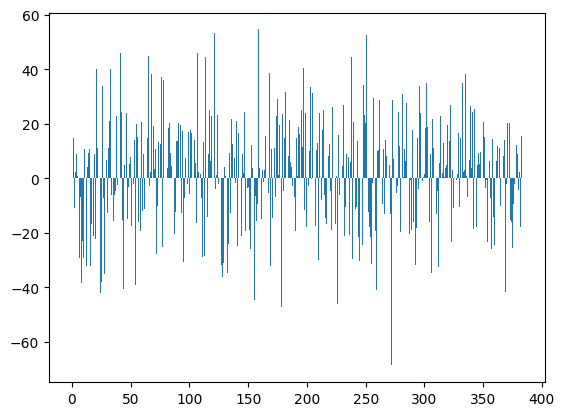

In [133]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


## After training the adapter_matrix, the next step is:

Now, input a query, and get the query_embedding vector through emb_func,  
Then multiply the query_embedding and the adapter_matrix to get the updated_query_embedding vector,   
Then use the updated_query_embedding vector to query the top-k most similar results using the chromadb query function (because of the adapter_matrix, the accuracy of the results found at this time is higher, that is, these k results are more related to the query text);  
Input the query and results together into llm to get the result.

In [187]:
query=input()


 tell me more about registration.


In [188]:
adapter_matrix=best_matrix

In [156]:
print(type(adapter_matrix))
print(adapter_matrix.shape)

<class 'numpy.ndarray'>
(384, 384)


In [189]:
query_embedding=emb_func([query]) # Do not enter emb_func(query) directly, otherwise a 1*384 vector will be generated for each character.
print(len(query_embedding))
print(len(query_embedding[0]))

1
384


In [190]:
query_embedding_np = np.array(query_embedding)
print(query_embedding_np.shape)


(1, 384)


## Query_emb and adapter_matrix matrix multiplication
note that it is np multiplication, format conversion

In [191]:
updated_query_emb_np = np.matmul(adapter_matrix, query_embedding_np.T)

print(type(updated_query_emb_np))
print(updated_query_emb_np.shape)

<class 'numpy.ndarray'>
(384, 1)


In [192]:
updated_query_emb=updated_query_emb_np.T.tolist() 
# Note that it is a 2-layer array, and both the inner and outer layers need to be converted from np to list

print(type(updated_query_emb))
print(type(updated_query_emb[0]))
print(len(updated_query_emb))
print(len(updated_query_emb[0]))

# print(updated_query_emb[0])

<class 'list'>
<class 'list'>
1
384


In [193]:
results = coll_adapter.query(query_embeddings=updated_query_emb, n_results=5, include=['documents', 'embeddings'])

results_original=coll_adapter.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])


In [194]:
results_doc=results['documents']
results_emb=results['embeddings']

results_doc_original=results_original['documents']
results_emb_original=results_original['embeddings']

In [195]:
print(len(results_doc))
print(len(results_doc[0]))
# print(results_doc[0])

print(len(results_emb))
print(len(results_emb[0]))
print(len(results_emb[0][0]))


1
5
1
5
384


In [196]:


information = "\n\n".join(results_doc[0])
information_original = "\n\n".join(results_doc_original[0])
# print(information)
def get_answer(query, information):
    messages = [
    {
        "role": "model",
        "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
        "I have given you some relevant information. Please answer the question."    
    },
     {"role": "user", "parts": f"Question: {query}. \n Information: {information}"}
    ]

    response = model.generate_content(messages)
    contents = response.text
    return contents

Google_API = input("Please input the Google Gemini API: ")
# print(Google_API)
genai.configure(api_key=Google_API)
model = genai.GenerativeModel(model_name="gemini-pro")



## Comparing the effects before and after using the adapter

I found that the effects were not good. . .


In [197]:
answer=get_answer(query, information)
print(answer)

I apologize, but the information you have provided does not include any details about registration.


In [198]:
answer_original=get_answer(query, information_original)
print(answer_original)

I am sorry, but the information you provided does not contain any information about registration.


In [ ]:
print(information)

## Combining query expansion method and embedding adapter

In [206]:
def augment_multiple_query(query): 
    messages = [
        {
            "role": "model",
            "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
                    "Generate 5 important related short questions based on the the question given to you."
                    "Do not output any compound questions (questions that contain multiple sentences or conjunctions)."
                    "Output each question on a separate line, separated by a line break."
        },
        {"role": "user", "parts": f"Question: {query}"}
    ]

    response = model.generate_content(messages)
    contents = response.text
    # print('contents from augment_example_answer: \n ', contents)
    return contents

In [201]:
def augment_example_answer(query):

    messages = [
        {
            "role": "model",
            "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
            "Provide an example answer to the given question, that might be found in a document like a student MSCS Handbook. "
        },
        {"role": "user", "parts":  f"Question: {query}"}
    ]

    response = model.generate_content(messages)
    contents = response.text
    # print('contents from augment_example_answer: \n ', contents)
    return contents

In [207]:
print(query)
hypothetical_answer = augment_example_answer(query)
augmented_queries = augment_multiple_query(query)

joint_query = f"the original question is: {query}, \n and the related short questions are: {augmented_queries}, \n the hypothetical answer is: {hypothetical_answer}"

print(joint_query)



tell me more about registration.
the original question is: tell me more about registration., 
 and the related short questions are: - What are the dates for the next registration period?
- How do I create a registration plan?
- Can you help me interpret my registration status?
- What is the difference between a hold and a block?
- How can I change my registration after I have submitted it?, 
 the hypothetical answer is: **Registration**

Registration is the process of selecting the courses you will take for the upcoming semester. It is important to choose courses that fulfill your graduation requirements and align with your interests.

**Steps for Registering**

1. **Check your registration time:** Your registration time will be assigned based on your academic standing and major. You can find your registration time on your student portal.
2. **Meet with your advisor:** Before registering, it is recommended to meet with your advisor to discuss course selection and create a plan for your

In [209]:
print(type(augmented_queries))
augmented_queries_arr=augmented_queries.split('\n')
print(augmented_queries_arr)

<class 'str'>
['- What are the dates for the next registration period?', '- How do I create a registration plan?', '- Can you help me interpret my registration status?', '- What is the difference between a hold and a block?', '- How can I change my registration after I have submitted it?']



Because the hypothetical answer is very long, and the related questions are very short.  
You can input the original question and related questions as a list jointed_query to chromadb to find information,  
and then give the final answer based on the jointed_query+information+hypothetical_answer.


In [210]:
jointed_query=[query]+augmented_queries_arr
print(len(jointed_query))

6


In [211]:
jointed_query_emb = emb_func(jointed_query)
print(len(jointed_query_emb))
print(len(jointed_query_emb[0]))



6
384


## Convert jointed_query_emb to np and multiply it with adapter_matrix

In [212]:
jointed_query_emb_np = np.array(jointed_query_emb)
print(jointed_query_emb_np.shape)

(6, 384)


In [214]:
updated_jointed_query_emb_np = np.matmul(adapter_matrix, jointed_query_emb_np.T)

updated_jointed_query_emb=updated_jointed_query_emb_np.T.tolist() # 注意是2层array，需要内外层都从np转为list

print(len(updated_jointed_query_emb))
print(len(updated_jointed_query_emb[0]))


6
384


In [223]:
results_jointed = coll_adapter.query(query_embeddings=updated_jointed_query_emb, n_results=5, include=['documents'])
results_jointed_doc=results['documents']

information_jointed = "\n\n".join(results_jointed_doc[0])

print(information_jointed)


return early and to confirm their academics will not be negatively impacted going forward. for a full review of georgia tech ’ s withdrawal policy, please review the registrar ’ s office page for withdrawal and dropping courses. leave of absence / application to return students may have extenuating circumstances that require them to miss multiple semesters ( e. g. military service ). in this instance, a student can apply to take a leave of absence. the student will submit an application to request a leave of absence and, if approved, eventually an “ application to return ” once the student is ready to return to georgia tech. the office of the registrar is responsible for reviewing and approving leave of absence applications. for a full review of the leave of absence policy, steps to take, and access to appropriate applications - please review the registrar ’ s office leave of absence page.

15 international students – withdrawing from a course while withdrawing from a course can certai

In [227]:
def get_answer_jointed(original_query, related_query, hypothetical_ans, information):
    messages = [
    {
        "role": "model",
        "parts": "You are a computer science advisor at a university. You help students with questions about course selection, graduation requirements, and majors to help them adjust to the university curriculum."
        "I have given you Related Questions related to the Original Question, the Hypothetical Answer of the Original Question, and some Reference Information. Please answer the Original Question."    
    },
     {
         "role": "user", 
         "parts": f"Original Question: {original_query}. \n Related Questions:{related_query}. \n Hypothetical Answer: {hypothetical_ans}. \n Reference Information: {information}"
     }
    ]

    response = model.generate_content(messages)
    contents = response.text
    return contents

In [221]:


Google_API = input("Please input the Google Gemini API: ")
# print(Google_API)

genai.configure(api_key=Google_API)
model = genai.GenerativeModel(model_name="gemini-pro")



In [228]:
answer=get_answer_jointed(query,augmented_queries,hypothetical_answer,information_jointed)

In [229]:
print(answer)

**Registration** is the process of selecting and enrolling in courses for a semester. Here's a brief overview:

**Steps:**

1. **Check registration dates:** Determine the designated registration period for your academic level and major.
2. **Meet with your advisor:** Discuss your course selections, graduation requirements, and major-specific recommendations.
3. **Select courses:** Browse the course catalog and choose courses that align with your program and interests.
4. **Build a schedule:** Create a schedule that accommodates your availability and course requirements.
5. **Register:** Input your course selections through the university's online registration system or meet with a registration representative.

**Course Load:**

Full-time graduate students typically carry 9-12 credit hours per semester, but this may vary depending on your progress and circumstances.

**Add/Drop Courses:**

During the first few weeks of the semester, you may adjust your schedule by adding or dropping cou